<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_lfw_MTCNN_cnn_DEMO_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lfw-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F26922%2F34595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T175551Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6de8a5cbced67ad86f40d630ae44a7ed334232402744dda8dcef593d3aced9bd18ba7c6202c021d7b95f78dfcc596b78594df364cf36599c421823b25a7e003a1e8e789fcbc3fa504c85a17c2dd385ebb4b4359ed767055bcd6b0855c9828b6e379be79938a2f51ae6a7af802a8a3b000a34c59838256d228a62d60b1bb488b9d8a913e149b560dca58ef73806d81aae22dbd766c28e8b2dee1fc4eeef0ebcea2384811a36592a6a78eef56e4bdb17d6075c659e806ebb22e517cbdcc4dc67bdd7b20a64dc8775720d281f0f7ec69d8da8baad64d3d079641772c299fd5478ab445fdb084279cec350a8cc701a8edd0f66cd336edba400506a2874f1c3a4250f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117895655 bytes downloaded
Downloaded and uncompressed: lfw-dataset
Data source import complete.


In [2]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.1 MB/s eta 0:00:00


#Import Dependencies

In [3]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


#1. Load the LFW-Dataset

> Load the dataset from kaggle.

> Filter instances of people with at least (N) of instances in their respective class

In [4]:
# Set the dataset path
dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Generate a list of (name, image count) tuples
names_images = []

for name in os.listdir(dataset_path):
    directory = os.path.join(dataset_path, name)
    if os.path.isdir(directory):
        images = [i for i in os.listdir(directory) if i.endswith('.jpg')]
        image_count = len(images)
        # Add to list if there are at least 20 images and store the actual image count
        if image_count >= 20:
            names_images.append((name, min(image_count, 20)))

# Update number_of_people to reflect the actual number of people with at least 25 images
number_of_people = len(names_images)
print(f"Number of people with at least 20 images: {number_of_people}")

# Create a DataFrame
lfw_allnames = pd.DataFrame(names_images, columns=['name', 'images'])

# Save the DataFrame to a CSV file
lfw_csv_path = '../input/lfw-dataset/lfw_allnames.csv'
lfw_allnames.to_csv(lfw_csv_path, index=False)

print(f"CSV file created at: {lfw_csv_path}")

Number of people with at least 20 images: 62
CSV file created at: ../input/lfw-dataset/lfw_allnames.csv


#2. Create the LFW-data-refined directory containing the filtered classes

In [5]:
# Define a new directory for experiments
new_dir_path = '../lfw-data-experiment'

# Create the new directory if it doesn't exist
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

# Move the folders
for name, image_count in names_images:
    source_folder = os.path.join(dataset_path, name)
    destination_folder = os.path.join(new_dir_path, name)

    # Check if the destination folder already exists
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)

    # Move the folders
    if os.path.exists(source_folder):
        shutil.copytree(source_folder, destination_folder)
        # If there are more than 50 images, keep the first 50 and delete the rest
        images = sorted([i for i in os.listdir(destination_folder) if i.endswith('.jpg')])
        for img in images[50:]:  # Delete all images beyond the 25th
            os.remove(os.path.join(destination_folder, img))
    else:
        print(f"Folder for {name} does not exist in the dataset path.")

print("Folders moved successfully.")

Folders moved successfully.


In [6]:
import os
from mtcnn import MTCNN
import cv2
from PIL import Image

# Initialize MTCNN face detector
detector = MTCNN()

def extract_faces(directory, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the directory
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        output_folder = os.path.join(output_dir, folder_name)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # MTCNN expects RGB images
            result = detector.detect_faces(img)

            # If a face is detected, crop the image around the bounding box
            if result:
                x, y, width, height = result[0]['box']
                face = img[y:y+height, x:x+width]
                im = Image.fromarray(face)
                im.save(os.path.join(output_folder, image_name))

# Define your input directory and desired output directory
input_dir = '../lfw-data-experiment'
output_dir = '../lfw-Faces'

# Run the face extraction
extract_faces(input_dir, output_dir)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 45ms/step


In [7]:
import os

# Function to calculate the number of files and subdirectories in a directory
def directory_shape(directory):
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    file_count = sum([len(files) for r, d, files in os.walk(directory)])
    return len(subdirectories), file_count

# Path to the directory to be checked
dir_path = '../lfw-Faces'

# Get the shape of the directory
directory_shape(dir_path)


(62, 2063)

#3. Split Data into training and testing sets.

> Here, we can define the image size

> And we make sure the imges have their correct labels

> Convert labels to one-hot encoded for cross-entropy loss function

In [8]:

# Read the dataset
people_data = os.listdir(output_dir)
people = []
for item in people_data:
    person_images = os.listdir(os.path.join(output_dir, item))
    for person_image in person_images:
        people.append((item, os.path.join(output_dir, item, person_image)))

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Convert labels to one-hot encoded labels
label_encoder = LabelEncoder()
labels = people_df['person'].values
int_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(int_encoded)

# Correct the size of the images to match the CNN input
im_size = 150

# Initialize lists to store the images and labels
images = []
labels = []

# Load and preprocess the images
for index, row in people_df.iterrows():
    img = cv2.imread(row['path'])
    img = cv2.resize(img, (im_size, im_size))
    images.append(img)
    labels.append(row['person'])

images = np.array(images)
images = images.astype('float32') / 255.0

# Shuffle and split the dataset
images, y_onehot = shuffle(images, y_onehot, random_state=1)
train_x, test_x, train_y_onehot, test_y_onehot = train_test_split(images, y_onehot, test_size=0.3, random_state=415)

# Check the shapes again to make sure they match
print("train_x shape:", train_x.shape)
print("train_y_onehot shape:", train_y_onehot.shape)
print("test_x shape:", test_x.shape)
print("test_y_onehot shape:", test_y_onehot.shape)

train_x shape: (1444, 150, 150, 3)
train_y_onehot shape: (1444, 62)
test_x shape: (619, 150, 150, 3)
test_y_onehot shape: (619, 62)


#4. Check the shape of the data

In [9]:
import pandas as pd

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Count the number of samples for each person
person_count = people_df['person'].value_counts()

print("Total number of images of people in the dataset: ", len(people_df))
print("Samples in each category: ")
print(person_count)


Total number of images of people in the dataset:  2063
Samples in each category: 
person
Gerhard_Schroeder    50
John_Ashcroft        50
Colin_Powell         50
Donald_Rumsfeld      50
Hugo_Chavez          50
                     ..
Igor_Ivanov          20
Michael_Bloomberg    20
Paul_Bremer          20
Jiang_Zemin          20
Angelina_Jolie       20
Name: count, Length: 62, dtype: int64


#5. Explore the data

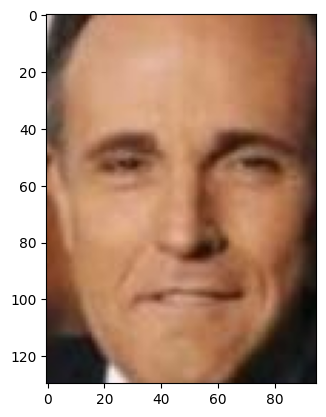

In [10]:
import cv2
from mtcnn import MTCNN
import matplotlib.pyplot as plt

image_path = people_df['path'][10]

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN

plt.imshow(image)

#6. Detec the face and keypoints of the sample.

1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 226ms/step


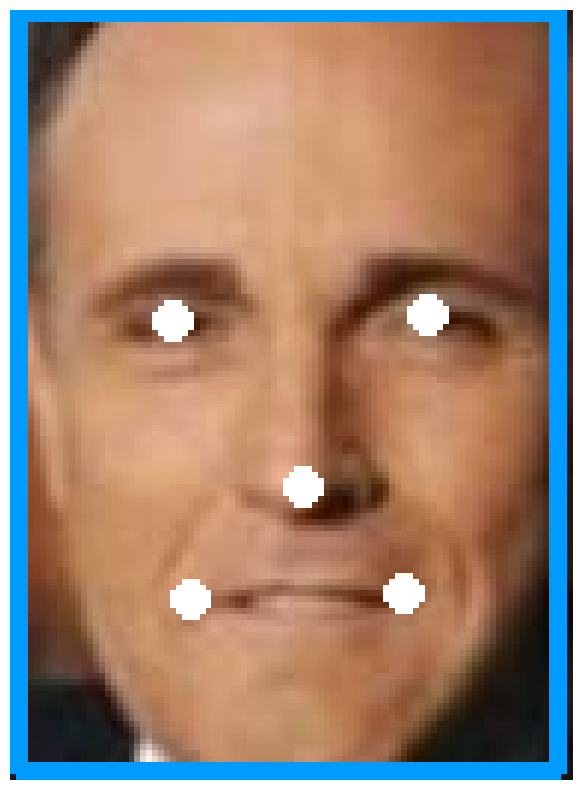

In [11]:
# Initialize MTCNN
detector = MTCNN()

# Detect faces in the image
faces = detector.detect_faces(image)

# Now, let's plot the image along with the detected keypoints
for face in faces:
    bounding_box = face['box']
    keypoints = face['keypoints']

    # Draw rectangle around the face
    cv2.rectangle(image,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,155,255),
                  2)

    # Draw circles for keypoints
    for key, point in keypoints.items():
        cv2.circle(image, point, 2, (255, 255, 255), 2)

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()


#7. Define Model Architecture

In [12]:
num_classes = len(np.unique(labels))
# im_shape=(im_size, im_size, 3)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(im_size, im_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the results to feed into a dense layer
    Flatten(),

    # 256 neurons in the fully connected layer
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout for regularization

    # Output layer with one neuron per class
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                        

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# train_datagen.fit(train_x)

#8. Train the model

> Define the number of epochs for the model to train

> More epoch more time, but if the model is learning corrreclty more accurate predictions


In [14]:
history = model.fit(
    train_x,
    train_y_onehot,
    epochs=50,
    batch_size=32,
    validation_data=(test_x, test_y_onehot)
)

Epoch 1/50
46/46 [==============================] - 8s 61ms/step - loss: 4.2009 - accuracy: 0.0492 - val_loss: 4.1141 - val_accuracy: 0.0452
Epoch 2/50
46/46 [==============================] - 2s 38ms/step - loss: 3.6953 - accuracy: 0.1233 - val_loss: 4.1001 - val_accuracy: 0.0436
Epoch 3/50
46/46 [==============================] - 2s 36ms/step - loss: 3.2588 - accuracy: 0.2091 - val_loss: 4.0393 - val_accuracy: 0.0679
Epoch 4/50
46/46 [==============================] - 2s 35ms/step - loss: 2.7654 - accuracy: 0.3075 - val_loss: 3.8907 - val_accuracy: 0.1632
Epoch 5/50
46/46 [==============================] - 2s 36ms/step - loss: 2.2356 - accuracy: 0.4065 - val_loss: 3.6759 - val_accuracy: 0.2924
Epoch 6/50
46/46 [==============================] - 2s 36ms/step - loss: 1.8380 - accuracy: 0.5000 - val_loss: 3.4666 - val_accuracy: 0.2633
Epoch 7/50
46/46 [==============================] - 2s 35ms/step - loss: 1.4573 - accuracy: 0.5956 - val_loss: 2.9925 - val_accuracy: 0.4152
Epoch 8/50
46

#9. Visualise Accuracy plots and Analise results

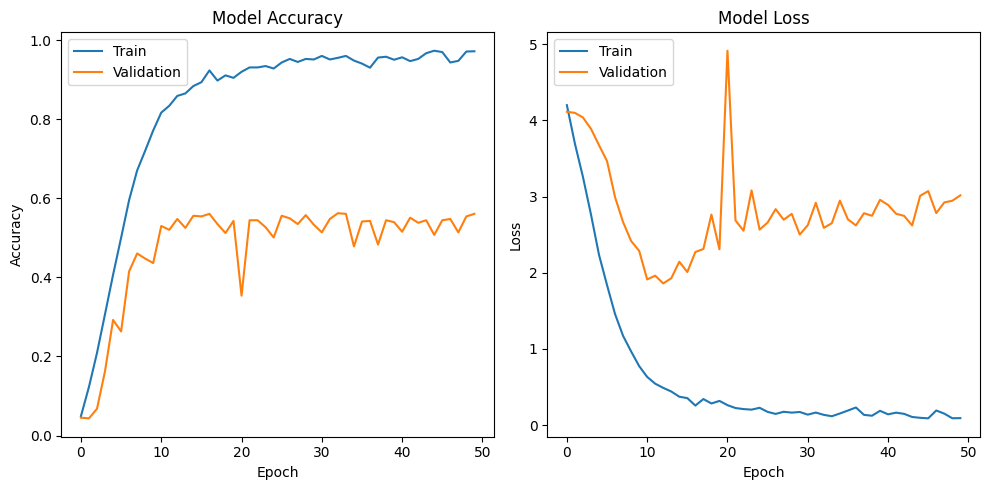

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


#Evaluate model on unseen data

> Confusion matrix compares true and false prediction, we know the model is performing well if these two coinside.

> the bright a square is the more confident the network is when predicting for that given class

20/20 [==============================] - 0s 9ms/step


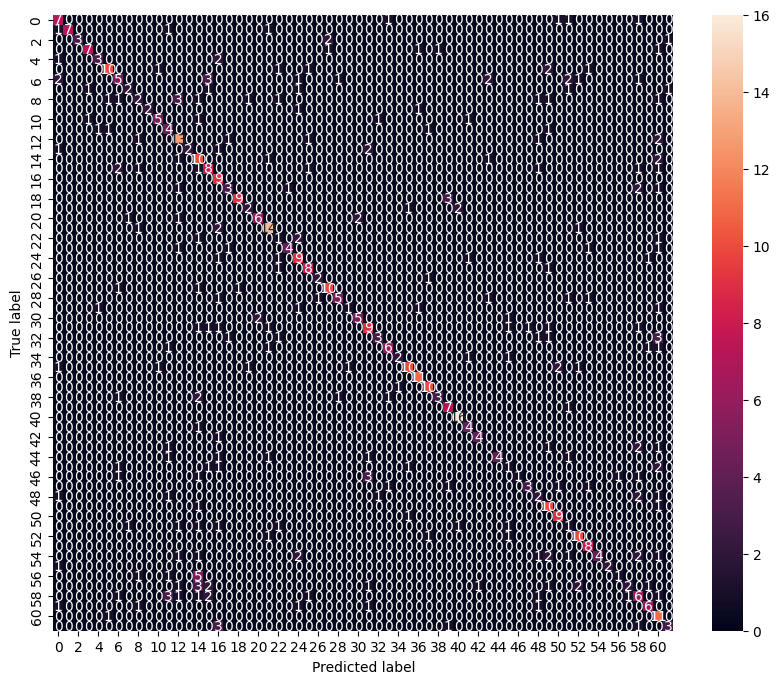

                           precision    recall  f1-score   support

         Alejandro_Toledo       0.44      0.64      0.52        11
             Alvaro_Uribe       1.00      0.70      0.82        10
          Amelie_Mauresmo       1.00      0.50      0.67         6
             Andre_Agassi       0.78      0.64      0.70        11
           Angelina_Jolie       0.60      0.50      0.55         6
             Ariel_Sharon       0.77      0.62      0.69        16
    Arnold_Schwarzenegger       0.38      0.28      0.32        18
     Atal_Bihari_Vajpayee       0.50      0.29      0.36         7
             Bill_Clinton       0.29      0.15      0.20        13
             Carlos_Menem       1.00      0.50      0.67         4
             Colin_Powell       0.71      0.56      0.63         9
            David_Beckham       0.31      0.50      0.38         8
          Donald_Rumsfeld       0.54      0.68      0.60        19
         George_Robertson       1.00      0.33      0.50     

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Generate predictions
test_y_pred = model.predict(test_x)
test_y_pred_classes = np.argmax(test_y_pred, axis=1)
test_y_true = np.argmax(test_y_onehot, axis=1)

# Print the confusion matrix
conf_matrix = confusion_matrix(test_y_true, test_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print(classification_report(test_y_true, test_y_pred_classes, target_names=label_encoder.classes_))


In [17]:
alexnet = Sequential()

# Layer 1
alexnet.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(im_size, im_size, 3)))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())

# Layer 4
alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())

# Layer 5
alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(4096, activation='relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(4096, activation='relu'))
alexnet.add(Dropout(0.5))

# Layer 8 - Output layer for binary classification
alexnet.add(Dense(num_classes, activation='softmax'))

# Compile the model
alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 35, 35, 96)        34944     
                                                                 
 batch_normalization_1 (Bat  (None, 35, 35, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 17, 17, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 17, 17, 256)       614656    
                                                                 
 batch_normalization_2 (Bat  (None, 17, 17, 256)       1024      
 chNormalization)                                                
                                                      

In [18]:
alex_history = alexnet.fit(
    train_x,
    train_y_onehot,
    epochs=50,
    batch_size=32,
    validation_data=(test_x, test_y_onehot)
)

Epoch 1/50
46/46 [==============================] - 9s 64ms/step - loss: 8.7316 - accuracy: 0.0298 - val_loss: 9.1863 - val_accuracy: 0.0291
Epoch 2/50
46/46 [==============================] - 2s 34ms/step - loss: 4.1772 - accuracy: 0.0506 - val_loss: 4.2182 - val_accuracy: 0.0258
Epoch 3/50
46/46 [==============================] - 1s 31ms/step - loss: 3.9020 - accuracy: 0.0845 - val_loss: 4.1157 - val_accuracy: 0.0307
Epoch 4/50
46/46 [==============================] - 2s 34ms/step - loss: 3.7368 - accuracy: 0.1087 - val_loss: 3.9322 - val_accuracy: 0.0533
Epoch 5/50
46/46 [==============================] - 2s 34ms/step - loss: 3.6355 - accuracy: 0.1163 - val_loss: 3.5909 - val_accuracy: 0.1082
Epoch 6/50
46/46 [==============================] - 2s 36ms/step - loss: 3.4393 - accuracy: 0.1627 - val_loss: 4.2261 - val_accuracy: 0.0808
Epoch 7/50
46/46 [==============================] - 1s 32ms/step - loss: 3.3229 - accuracy: 0.1828 - val_loss: 5.3783 - val_accuracy: 0.0517
Epoch 8/50
46

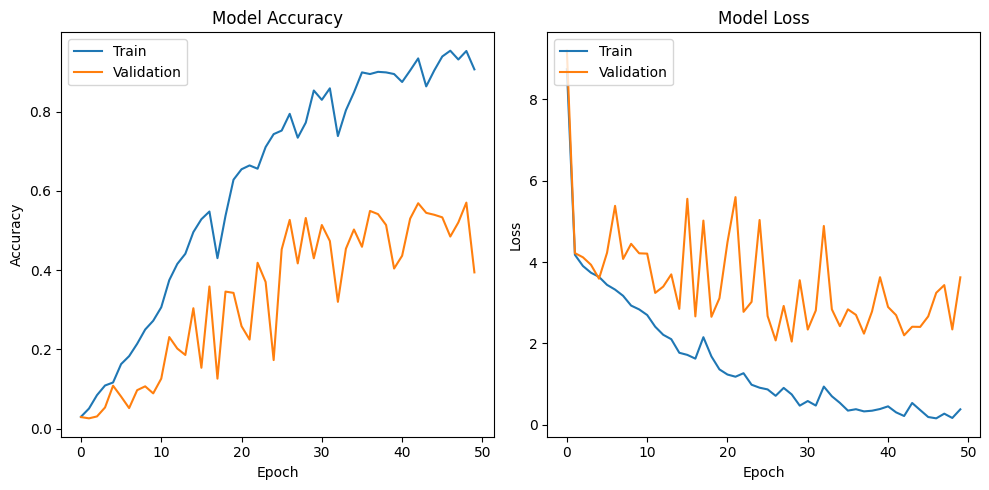

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(alex_history.history['accuracy'])
plt.plot(alex_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(alex_history.history['loss'])
plt.plot(alex_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


20/20 [==============================] - 0s 11ms/step


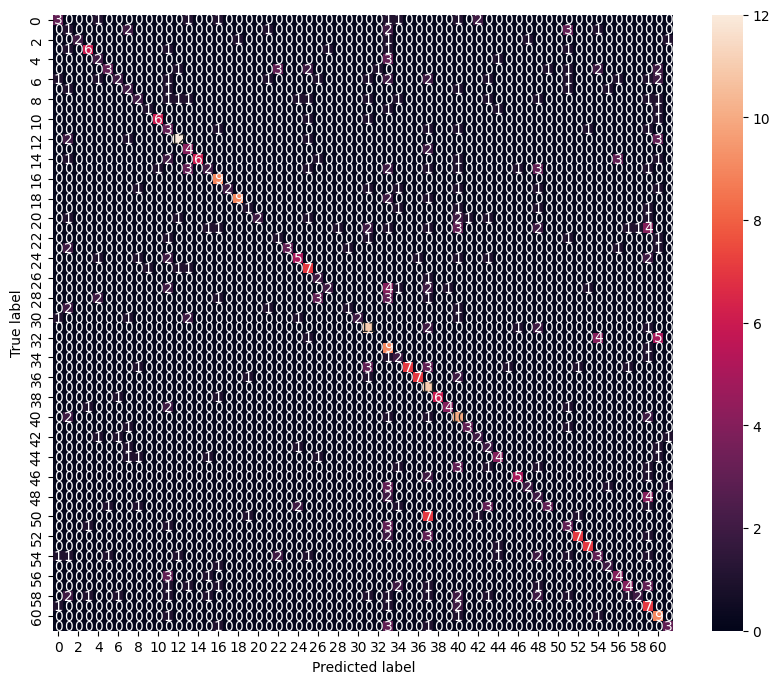

                           precision    recall  f1-score   support

         Alejandro_Toledo       0.43      0.27      0.33        11
             Alvaro_Uribe       0.06      0.10      0.08        10
          Amelie_Mauresmo       1.00      0.33      0.50         6
             Andre_Agassi       0.67      0.55      0.60        11
           Angelina_Jolie       0.25      0.33      0.29         6
             Ariel_Sharon       0.60      0.19      0.29        16
    Arnold_Schwarzenegger       0.40      0.11      0.17        18
     Atal_Bihari_Vajpayee       0.22      0.29      0.25         7
             Bill_Clinton       0.29      0.15      0.20        13
             Carlos_Menem       0.50      0.25      0.33         4
             Colin_Powell       0.86      0.67      0.75         9
            David_Beckham       0.13      0.38      0.19         8
          Donald_Rumsfeld       0.71      0.63      0.67        19
         George_Robertson       0.31      0.67      0.42     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Generate predictions
test_y_pred = alexnet.predict(test_x)
test_y_pred_classes = np.argmax(test_y_pred, axis=1)
test_y_true = np.argmax(test_y_onehot, axis=1)

# Print the confusion matrix
conf_matrix = confusion_matrix(test_y_true, test_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print(classification_report(test_y_true, test_y_pred_classes, target_names=label_encoder.classes_))


In [21]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Activation

vgg_classifier = Sequential()

# Block 1
vgg_classifier.add(ZeroPadding2D((1,1), input_shape=(im_size, im_size, 3)))
vgg_classifier.add(Conv2D(64, (3, 3), activation='relu'))
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(64, (3, 3), activation='relu'))
vgg_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block2
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(128, (3, 3), activation='relu'))
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(128, (3, 3), activation='relu'))
vgg_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block3
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(256, (3, 3), activation='relu'))
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(256, (3, 3), activation='relu'))
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(256, (3, 3), activation='relu'))
vgg_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block 4
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(512, (3, 3), activation='relu'))
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(512, (3, 3), activation='relu'))
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(512, (3, 3), activation='relu'))
vgg_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

# Block 5
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(512, (3, 3), activation='relu'))
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(512, (3, 3), activation='relu'))
vgg_classifier.add(ZeroPadding2D((1,1)))
vgg_classifier.add(Conv2D(512, (3, 3), activation='relu'))
vgg_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

# Custom Classifier Layers
vgg_classifier.add(Flatten())
vgg_classifier.add(Dense(1024, activation='relu'))
vgg_classifier.add(Dropout(0.5))
vgg_classifier.add(Dense(1024, activation='relu'))
vgg_classifier.add(Dropout(0.5))
# Output layer for categorical  classification
vgg_classifier.add(Dense(num_classes, activation='softmax'))

# Compile model
vgg_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

vgg_classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 152, 152, 3)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 152, 152, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_33 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 75, 75, 64)        0         
 ng2D)                                                           
                                                      

In [22]:
vgg_history = vgg_classifier.fit(
    train_x,
    train_y_onehot,
    epochs=50,
    batch_size=32,
    validation_data=(test_x, test_y_onehot)
)

Epoch 1/50
46/46 [==============================] - 36s 435ms/step - loss: 4.1724 - accuracy: 0.0180 - val_loss: 4.1170 - val_accuracy: 0.0129
Epoch 2/50
46/46 [==============================] - 12s 250ms/step - loss: 4.0926 - accuracy: 0.0180 - val_loss: 4.1203 - val_accuracy: 0.0145
Epoch 3/50
46/46 [==============================] - 11s 247ms/step - loss: 4.0823 - accuracy: 0.0256 - val_loss: 4.1125 - val_accuracy: 0.0129
Epoch 4/50
46/46 [==============================] - 12s 268ms/step - loss: 4.0817 - accuracy: 0.0229 - val_loss: 4.1166 - val_accuracy: 0.0129
Epoch 5/50
46/46 [==============================] - 11s 239ms/step - loss: 4.0824 - accuracy: 0.0256 - val_loss: 4.1147 - val_accuracy: 0.0145
Epoch 6/50
46/46 [==============================] - 11s 240ms/step - loss: 4.0781 - accuracy: 0.0249 - val_loss: 4.1250 - val_accuracy: 0.0129
Epoch 7/50
46/46 [==============================] - 12s 266ms/step - loss: 4.0732 - accuracy: 0.0187 - val_loss: 4.1267 - val_accuracy: 0.0129

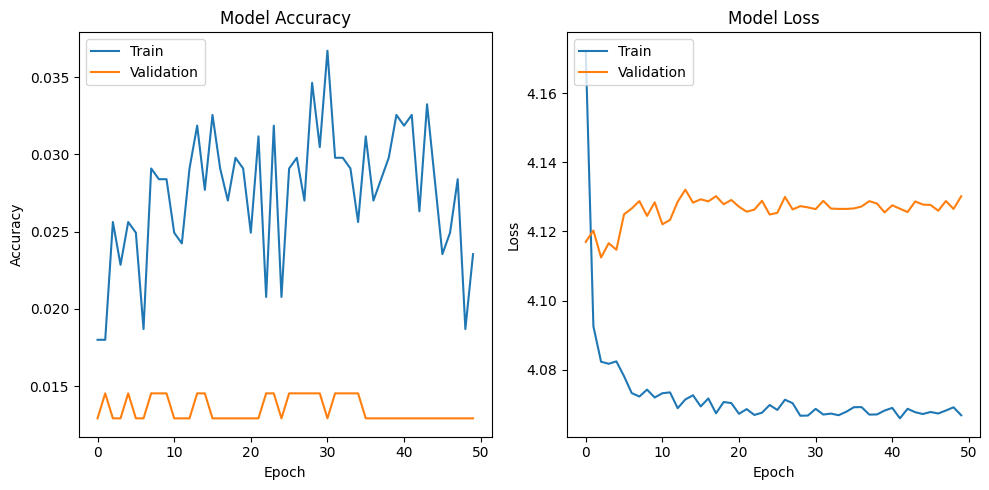

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


20/20 [==============================] - 1s 69ms/step


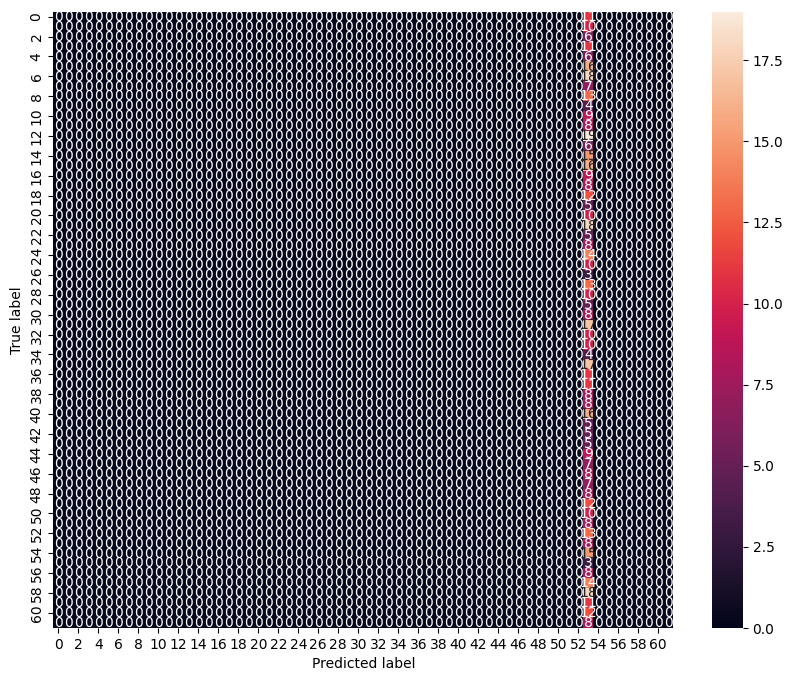

                           precision    recall  f1-score   support

         Alejandro_Toledo       0.00      0.00      0.00        11
             Alvaro_Uribe       0.00      0.00      0.00        10
          Amelie_Mauresmo       0.00      0.00      0.00         6
             Andre_Agassi       0.00      0.00      0.00        11
           Angelina_Jolie       0.00      0.00      0.00         6
             Ariel_Sharon       0.00      0.00      0.00        16
    Arnold_Schwarzenegger       0.00      0.00      0.00        18
     Atal_Bihari_Vajpayee       0.00      0.00      0.00         7
             Bill_Clinton       0.00      0.00      0.00        13
             Carlos_Menem       0.00      0.00      0.00         4
             Colin_Powell       0.00      0.00      0.00         9
            David_Beckham       0.00      0.00      0.00         8
          Donald_Rumsfeld       0.00      0.00      0.00        19
         George_Robertson       0.00      0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Generate predictions
test_y_pred = vgg_classifier.predict(test_x)
test_y_pred_classes = np.argmax(test_y_pred, axis=1)
test_y_true = np.argmax(test_y_onehot, axis=1)

# Print the confusion matrix
conf_matrix = confusion_matrix(test_y_true, test_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print(classification_report(test_y_true, test_y_pred_classes, target_names=label_encoder.classes_))

In [25]:
cnn_history = model.fit(
    train_x,
    train_y_onehot,
    epochs=100,
    batch_size=32,
    validation_data=(test_x, test_y_onehot)
)

Epoch 1/100
46/46 [==============================] - 2s 46ms/step - loss: 0.1439 - accuracy: 0.9564 - val_loss: 2.8029 - val_accuracy: 0.5380
Epoch 2/100
46/46 [==============================] - 2s 33ms/step - loss: 0.3565 - accuracy: 0.8989 - val_loss: 5.4932 - val_accuracy: 0.3861
Epoch 3/100
46/46 [==============================] - 2s 35ms/step - loss: 0.2323 - accuracy: 0.9321 - val_loss: 3.5868 - val_accuracy: 0.4620
Epoch 4/100
46/46 [==============================] - 2s 35ms/step - loss: 0.1965 - accuracy: 0.9474 - val_loss: 2.8656 - val_accuracy: 0.5234
Epoch 5/100
46/46 [==============================] - 2s 33ms/step - loss: 0.1435 - accuracy: 0.9508 - val_loss: 2.8052 - val_accuracy: 0.5606
Epoch 6/100
46/46 [==============================] - 2s 33ms/step - loss: 0.1141 - accuracy: 0.9612 - val_loss: 2.7482 - val_accuracy: 0.5687
Epoch 7/100
46/46 [==============================] - 1s 33ms/step - loss: 0.1198 - accuracy: 0.9612 - val_loss: 2.9163 - val_accuracy: 0.5444
Epoch 

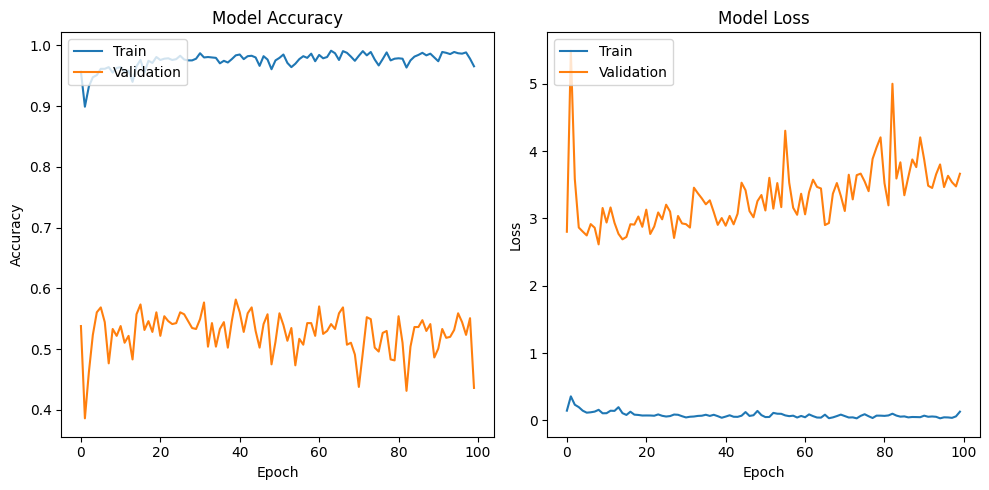

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

20/20 [==============================] - 0s 10ms/step


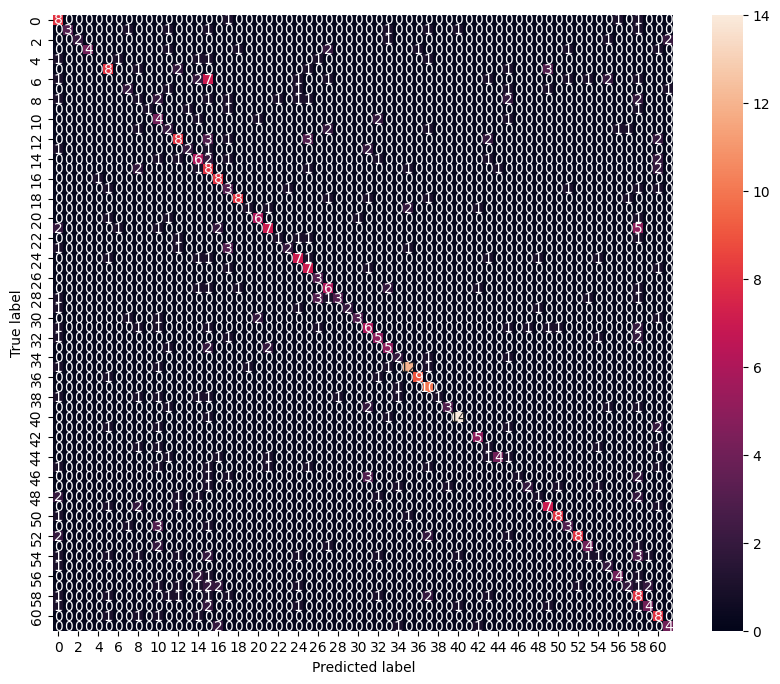

                           precision    recall  f1-score   support

         Alejandro_Toledo       0.26      0.73      0.38        11
             Alvaro_Uribe       1.00      0.30      0.46        10
          Amelie_Mauresmo       1.00      0.33      0.50         6
             Andre_Agassi       1.00      0.36      0.53        11
           Angelina_Jolie       0.00      0.00      0.00         6
             Ariel_Sharon       0.47      0.50      0.48        16
    Arnold_Schwarzenegger       0.00      0.00      0.00        18
     Atal_Bihari_Vajpayee       0.40      0.29      0.33         7
             Bill_Clinton       0.08      0.08      0.08        13
             Carlos_Menem       1.00      0.25      0.40         4
             Colin_Powell       0.18      0.44      0.26         9
            David_Beckham       0.20      0.25      0.22         8
          Donald_Rumsfeld       0.44      0.42      0.43        19
         George_Robertson       0.67      0.33      0.44     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Generate predictions
test_y_pred = model.predict(test_x)
test_y_pred_classes = np.argmax(test_y_pred, axis=1)
test_y_true = np.argmax(test_y_onehot, axis=1)

# Print the confusion matrix
conf_matrix = confusion_matrix(test_y_true, test_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print(classification_report(test_y_true, test_y_pred_classes, target_names=label_encoder.classes_))